# Quantifying Fire Safety through incidents reported by the Pittsburgh Bureau of Fire
#### Section by Diego Jurado
## Section 1: Metric Introduction
The investigation presents the opportunity to quantify "What a good a neighborhood is" and ultimately determine which is the best. I understood this to be which neighborhood is the most "family-friendly" and to me when considering where to raise a family safety is the main concern. The metrics I was considering to use were between burglary incidents and fire incidents to determine safety in neighborhoods. The deciding factor bewteen the two was that burglarly, besides quantity of burglary incidents, are much harder to quantify, while fire incidents have two safety factors that familys consider which are the rate at which incidents occur, and the average fire department response time. Consequently, my section of the investigation will seek to quantify these factors and rank the neighborhoods accordingly.
## Section 2: Python Extension Imports
Before we begin to manipulate any data we must import the appropriate libraries
#### The following code:
- Imports the `pandas` library
- Imports the `requests` library

In [230]:
import pandas as pd
import requests

## Section 3: Importing Data Tables
The dataset will be imported from the Western Pennsylvania Regional Data Center. The data within the file, `fire.csv` is the dataset that will be used to quanitfy the metric of fire safety throughout this section of the investigation. The dataset holds information regarding incidents of fire responded to by the Pittsburgh Bureau of Fire. Additionally, the dataset can be accessed online here: https://data.wprdc.org/dataset/fire-incidents-in-city-of-pittsburgh/resource/8d76ac6b-5ae8-4428-82a4-043130d17b02?view_id=db1ccf7c-fab0-4d5c-af3e-245ebe766be2 Moreover, the data within the file `stations.csv` is the dataset that will be used to calculate the average response time from station to incident based on neighborhood. The `stations.csv` dataset was created based off of information found online.

#### The following code:
- Imports `fire.csv` and `stations.csv`.
- Creates the `fire_raw` DataFrame and the `stations_raw` DataFrame.
- Formats the raw DataFrames into usable verisons by dropping unnecessary data.
- Creates the `fire` DataFrame and the `stations` DataFrame.
- Clears the `fire` DataFrame of any data that does not match the `stations` DataFrame.



In [231]:
# importing csv files and creating raw DataFrames
stations_raw = pd.read_csv("stations.csv").drop(columns=['station'])
fire_raw = (pd.read_csv("fire.csv")
        # drop unnecessary columns to investigation
       .drop(columns=['call_no','alarm_time','alarms', 'primary_unit', 
                      'census_tract', 'council_district', 'ward', 'tract', 
                      'public_works_division', 'pli_division', 'police_zone', 'address'])
       # drop any rows that contain any missing data
        .dropna()
        .drop_duplicates()
       .reset_index()
       .drop(columns='index'))

# creating fire and stations DataFrames
fire = fire_raw[['neighborhood', 'incident_type', 'type_description', 'fire_zone', 'latitude', 'longitude']]
stations = stations_raw[['neighborhood', 'station_no']]

# clearing the fire DataFrame of any non-matching data
fire = (fire.loc[fire.neighborhood.isin(stations.neighborhood),].reset_index().drop(columns='index'))

## Section 4: Quantifying Total Incidents per Neighborhood
After creating the DataFrames we can now move on to quantifying the first metric, Total Incident Quantity per Neighborhood. 

#### The following code:
- Creates a list, `neighborhood_list`.
- Creates a dictionary to count how many incidents occured per neighborhood.
- Creates a sorted version of the neighborhood list
- Creates a DataFrame, `incidents`, to store the dictionary.
- Displays the DataFrame as a bar graph

In [241]:
# Creating a list to store neighborhoods
neighborhood_list = []

for index, row in fire.iterrows():
    if row['neighborhood']not in neighborhood_list:
        neighborhood_list.append(row['neighborhood'])
        
# Creating a dictionary to store quantity of incidents
dict = {}
type(dict)
for index, row in fire.iterrows():
    if row['neighborhood'] not in dict:
        dict[row['neighborhood']] = 1
    else:
        dict[row['neighborhood']] += 1

# Creating a sorted version of the neighborhood list
index = sorted(neighborhood_list)

# Storing dictionary in a DataFrame
incidents = pd.DataFrame({'incidents_no': dict}, index=index)

### Figure 1: Bar Graph of Incident Quantity per Neighborhood

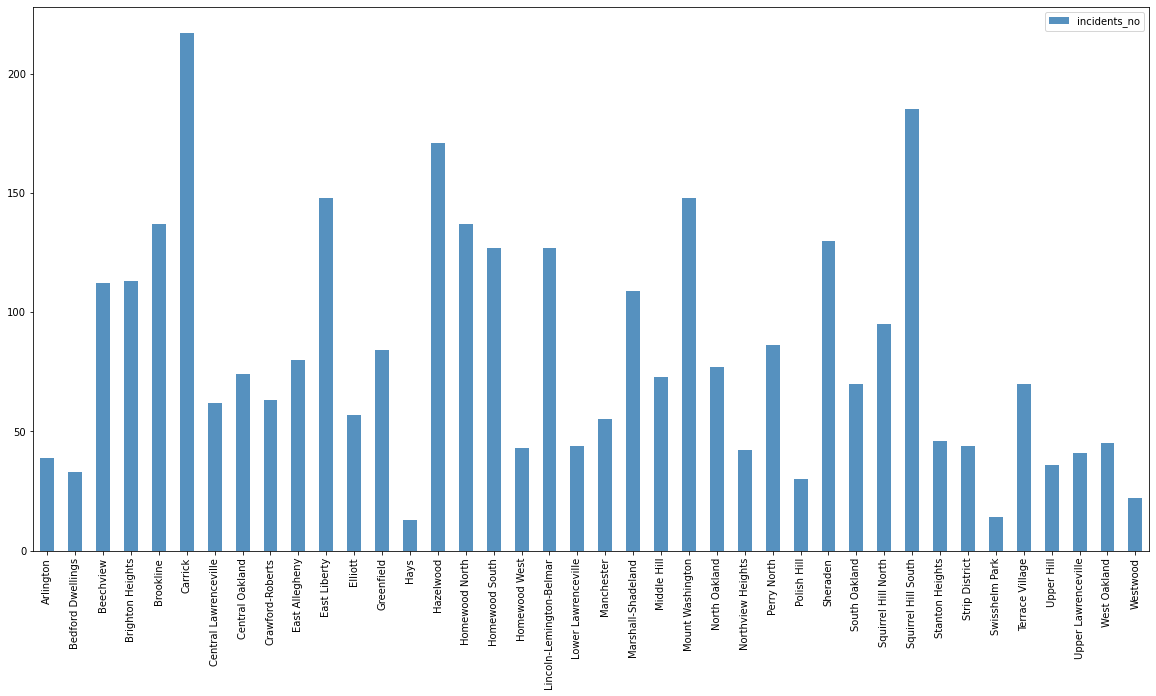

In [240]:
# Displaying the DataFrame as a Bar Graph
dx = incidents.plot.bar(rot=90, color="#5691BF", figsize=(20,10))

The bar graph displays each neighborhood and their total incident quantity. With this metric alone one could determine that the neighborhoods of Hays, Swisshelm Park, and Westwood would be the safest in regard to fire safety, while the neighborhoods of Carrick, Hazelwood, and Squirrel Hill South would be the most unsafe in regard to fire safety.
## Section 5: Utilizing Google Distance Matrix API
After quantifying the first metric, we move on to quantifying the second, which is calculating the average response time of the fire department per neighborhood. My thought processs was straightforward with this. I decided I would have to calculate the time between the station and incident location per incident and then classify it per neighborhood. However, the code was a bit more complex. I determined that the first step would be calculating the time between station and incident, which was facilitated by the Google Distance Matirx API. I had no experience with this and it was quite fun to employ. 

#### The following code:
- Creates a list, `response_time`.
- Opens the `api-key.txt` file, which contains the API key.
- Establishes a URL to access the Distance Matrix API.
- Accesses the Distance Matrix API for each incident.
- Stores the Distance Matrix API resulting time.
- Constructs a new column for the `fire` DataFrame titled `response_time` to store the `response_time` list.
- Prints a statement when it's finished running

In [233]:
# Creating a list to store response time
response_time = []

# API Key
api_file = open("api-key.txt","r")
api_key = api_file.read()
api_file.close()

# base URL
url = "https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&"

# accessing the API
for j, row in fire.iterrows():
    inc_nbr = row['neighborhood']
    destination = str(row['latitude']) + ", " + str(row['longitude']) 
    for k, row in stations.iterrows():
        stn_nbr = row['neighborhood']
        station_no = row['station_no']
        if inc_nbr == stn_nbr:
            origin = "Pittsburgh Fire Station " + str(station_no)
            
            # getting response from API
            r = requests.get(url + "origins=" + origin + "&destinations=" + destination + "&key=" + api_key)     
            seconds = r.json()["rows"][0]["elements"][0]["duration"]["value"]
            
            # storing the resulting time
            response_time.append(seconds)

# Constructing a new column for response time per incident
fire['response_time'] = response_time

# Printing indication that the code has finished running
print('This section has finished running.')

This section has finished running.


## Section 6: Creating a secondary dataframe with calculated values
After quantifying both metrics it is time to consolidate the data into one new DataFrame that will allow us to rank the best neighborhoods in Pittsburgh in regard to fire safety.

#### The following code:
- Creates a second dictionary for storing response time per neighborhood
- Creates a DataFrame for the calculated values
- Appends both dictionaries to the new DataFrame 

In [234]:
# Creating a second dictionary that stores total response time per neighborhood
dict2 = {}
type(dict2)
for index, row in fire.iterrows():
    if row['neighborhood'] not in dict2:
        dict2[row['neighborhood']] = row['response_time']
    else:
        dict2[row['neighborhood']] += row['response_time']

# Creating a second DataFrame with the calculated values
columns = ['neighborhood', 'incidents_no', 'avg_resp_time']
fire_pro = pd.DataFrame(columns=columns)

# Appending values to the new DataFrame
for x in neighborhood_list:
    avg_resp_time = (dict2[x]/dict[x])
    fire_pro = fire_pro.append({'neighborhood' : x , 'incidents_no' : dict[x], 'avg_resp_time' : avg_resp_time }, ignore_index = True) 

## Section 7: Graphing Data
### Creating lists to form DataFrames for graphing
Now that all the data needed has been calculated we can now move towards visualizing and arriving at our conclusion and consequently ranking. First we must create lists of data to then create specific sets for graphing purposes as there will be several bar graphs drawn for comparison purposes.
#### The following code:
- Initializes 3 new lists: incidents_no, avg_resp_time, and index
- Appends all 3 list with the appropriate data
- Displays a bar graph of average response time per incident per neighborhood
- Displays a bar graph of incident quantity per neighborhood
- Displays a bar graph of both average response time and incident quantity per neighborhood
- Displays a scatter plot of showing the relation between neighborhoods in regard to response time and incident quantity

In [235]:
incidents_no = []
avg_resp_time = []
index = []

for x, row in fire_pro.iterrows():
    incidents_no.append(row['incidents_no'])
    avg_resp_time.append(row['avg_resp_time'])
    index.append(row['neighborhood'])
    

### Figure 2: Bar Graph of Average Response Time per Incident per Neighborhood

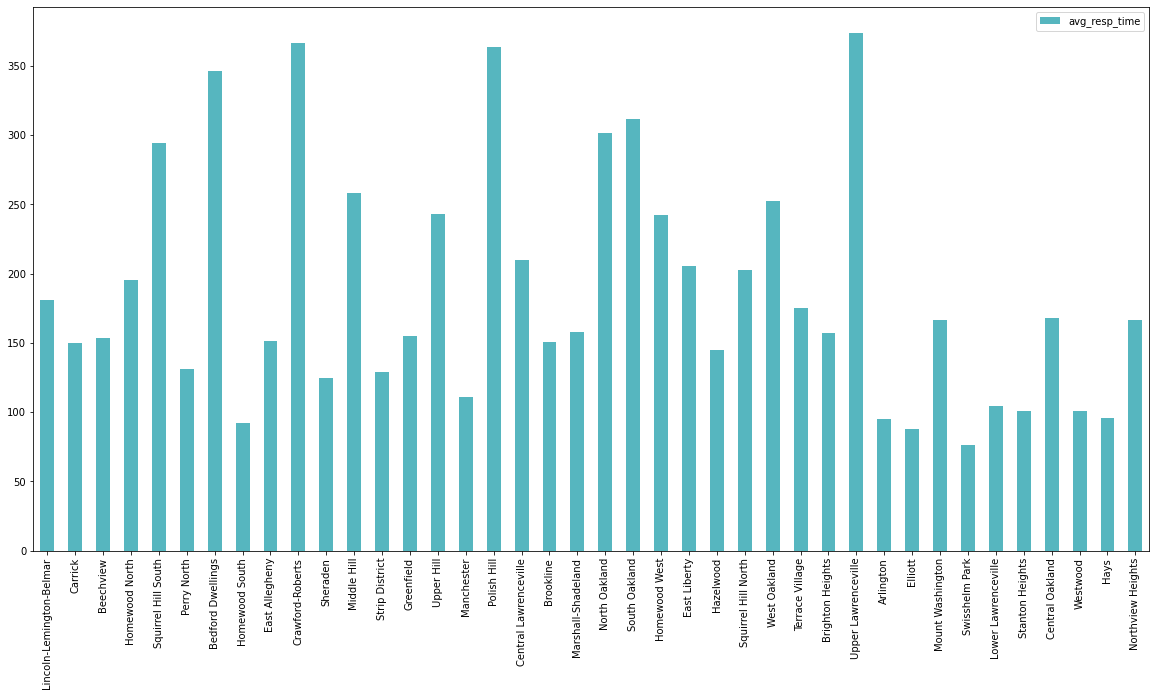

In [236]:
response_time=pd.DataFrame({ 'avg_resp_time': avg_resp_time}, index=index).plot.bar(rot=90,color="#56B6BF",figsize=(20,10))

### Figure 3: Bar Graph of Incident Quantity per Neighborhood

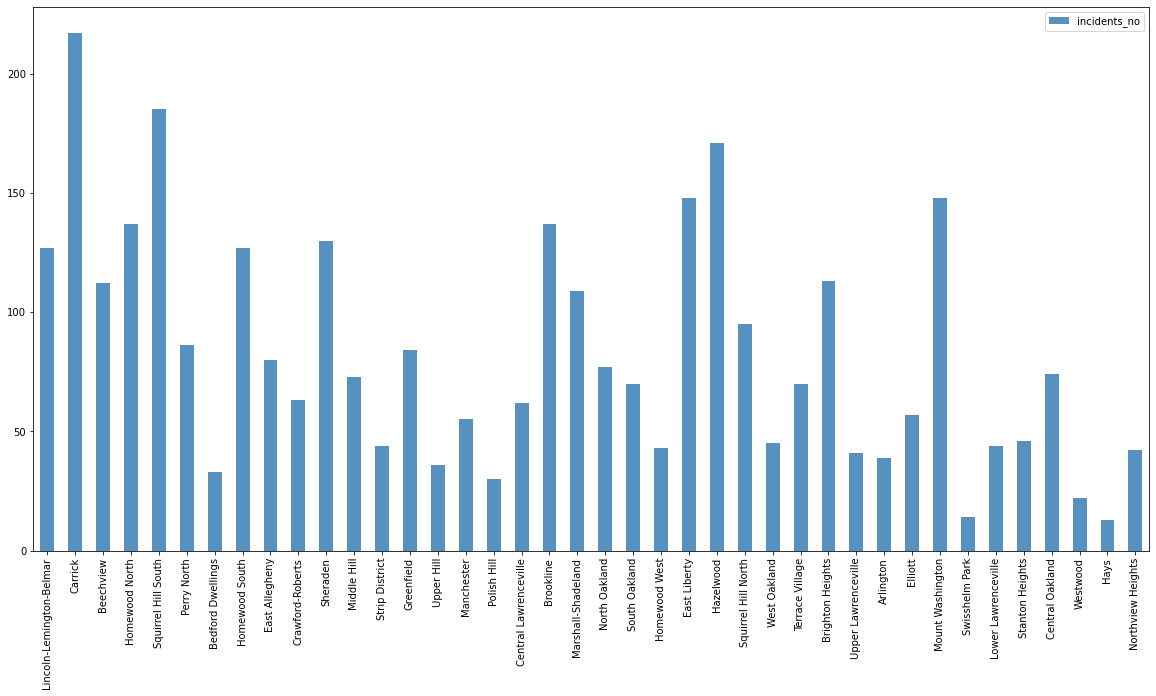

In [237]:
incident_quantity = pd.DataFrame({ 'incidents_no': incidents_no}, index=index).plot.bar(rot=90,color="#5691BF",figsize=(20,10))

### Figure 4: Bar Graph of both Average Response Time and Incident Quantity per Neighborhood

<AxesSubplot:>

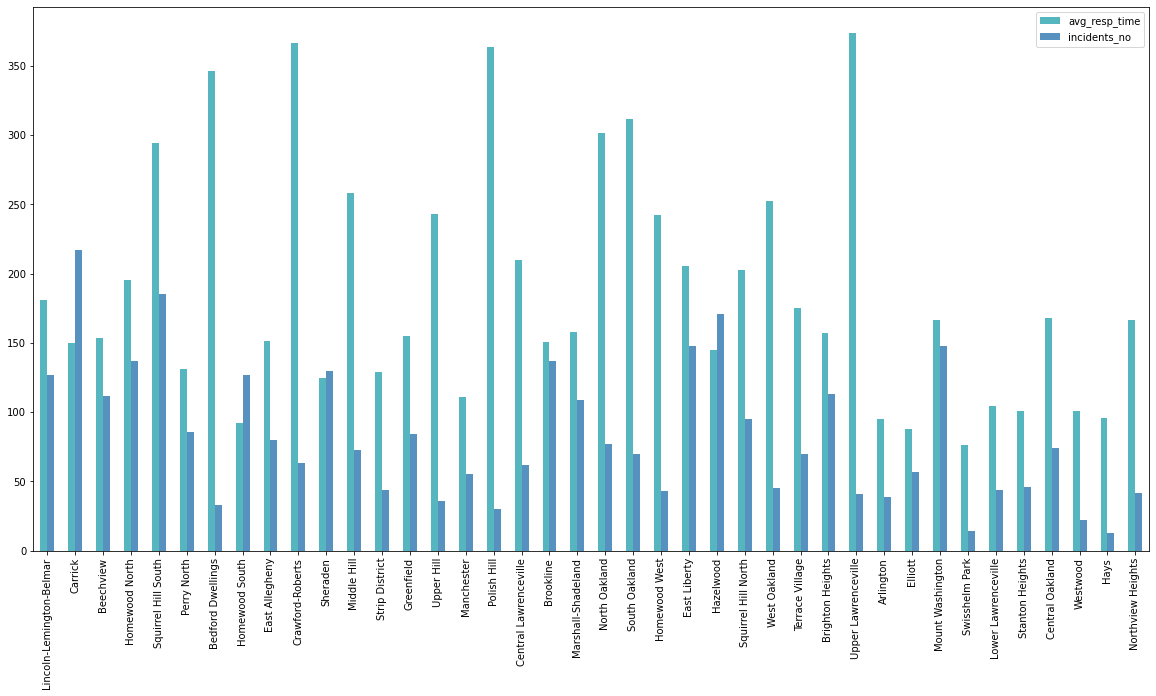

In [238]:
quantity_to_response = pd.DataFrame({'avg_resp_time': avg_resp_time, 'incidents_no': incidents_no}, index=index)
quantity_to_response.plot.bar(rot=90,color=["#56B6BF","#5691BF"], figsize=(20,10))

### Figure 5: Scatter Plot Graph Showing relation between neighborhoods in regard to Response Time and Incident Quantity

<AxesSubplot:xlabel='incidents_no', ylabel='avg_resp_time'>

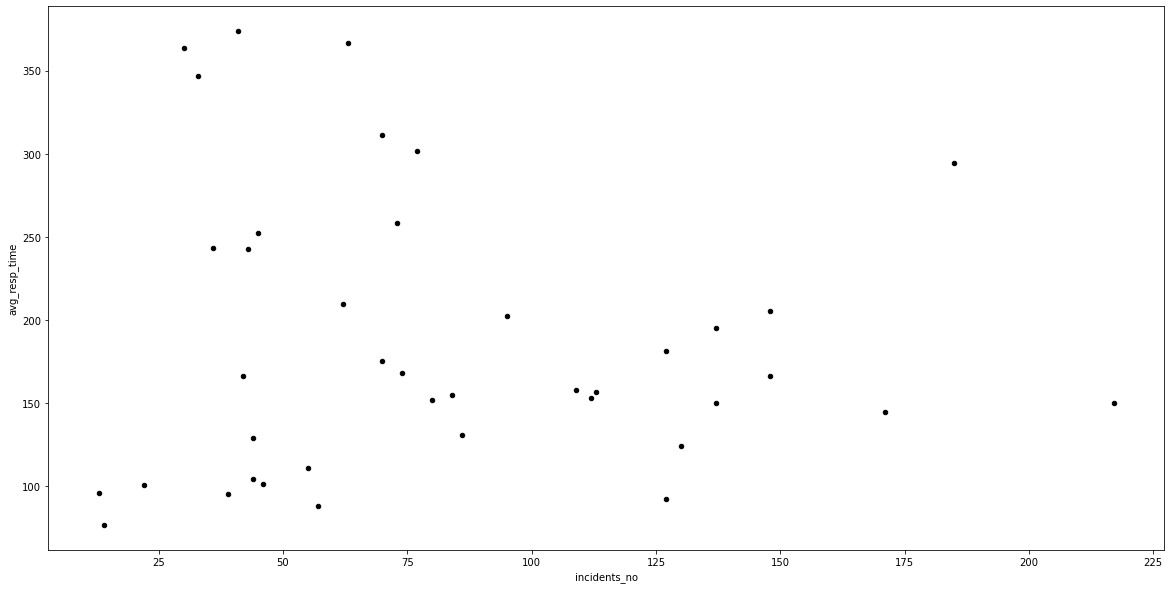

In [239]:
quantity_to_response.plot.scatter(x='incidents_no',y='avg_resp_time',color="#000000",figsize=(20,10))

## Section 8: Metric Conclusion
The scatter plot graph, figure 5, is the best for determining the overall metric rating, as the less distance there is between the origin and the point the higher the rank of the neighborhood is. In short, the top three neighborhoods are Manchester, Hays, and Swissshelm Park, with Swisshelm Park being the best for fire safety. However, it should be noted that these three have potential error in regard to average response time as they are limited in the quantity of incidents that have occured, and consequently have a smaller basis form response times to be calculated. Moreover, if one cares about one metric more than the other for example preferring average response time over incident number the top five choices would be Swisshelm Park, Arlington, Homewood South, Hays and Elliott. On the other hand, if one were to care more about the number of incidents, the top 5 would be Swisshelm Park, Westwood, Hays, Bedford Dwellings, and Polish Hill.